<a href="https://colab.research.google.com/github/Sinamhd9/Computer-vision-projects/blob/main/Homography-based%20Image%20Stitching/image_stitch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-contrib-python==4.4.0.44

In [2]:
import cv2
print(cv2.__version__)
import sys
import numpy as np
from google.colab.patches import cv2_imshow

def ex_find_homography_ransac(list_pairs_matched_keypoints, threshold_ratio_inliers=0.85, threshold_reprojtion_error=3,
                              max_num_trial=1000):
    '''
    Apply RANSAC algorithm to find a homography transformation matrix that align 2 sets of feature points, transform the first set of feature point to the second (e.g. warp image 1 to image 2)
    :param list_pairs_matched_keypoints: has the format as a list of pairs of matched points: [[[p1x,p1y],[p2x,p2y]],....]
    :param threshold_ratio_inliers: threshold on the ratio of inliers over the total number of samples, accept the estimated homography if ratio is higher than the threshold
    :param threshold_reprojtion_error: threshold of reprojection error (measured as euclidean distance, in pixels) to determine whether a sample is inlier or outlier
    :param max_num_trial: the maximum number of trials to do take sample and do testing to find the best homography matrix
    :return best_H: the best found homography matrix
    '''
    l = list_pairs_matched_keypoints
    print('length(list_pairs_matched_keypoints) =', len(l))
    u = np.zeros((len(l), 1))
    v = np.zeros((len(l), 1))
    up = np.zeros((len(l), 1))
    vp = np.zeros((len(l), 1))
    for i in range(len(l)):
        u[i] = l[i][0][0]
        v[i] = l[i][0][1]
        up[i] = l[i][1][0]
        vp[i] = l[i][1][1]
    num_trial = 0
    inlrNum = 0
    while num_trial < max_num_trial and inlrNum < int(threshold_ratio_inliers * len(l)):
        s = np.random.randint(len(u), size=(4, 1))
        A = np.zeros((0, 9))
        for i in range(len(s)):
            A = np.append(A,
                          np.array([[0, 0, 0, -u[s[i]], -v[s[i]], -1, vp[s[i]] * u[s[i]], vp[s[i]] * v[s[i]], vp[s[i]]],
                                    [u[s[i]], v[s[i]], 1, 0, 0, 0, -up[s[i]] * u[s[i]], -up[s[i]] * v[s[i]],
                                     -up[s[i]]]]).astype(int), axis=0)
            uu, ss, vh = np.linalg.svd(A, full_matrices=True)
            H = np.reshape(vh[-1, :], [3, 3])
        inlrNum = 0
        inlrs = []
        for (point1, point2) in l:
            p1H = np.reshape(np.append(point1, [1]), (3, 1))
            p1pred = np.matmul(H, p1H)
            p1pred = np.reshape(p1pred[:2] / p1pred[-1], (1, 2))
            p2H = np.reshape(np.append(point2, [1]), (3, 1))
            p2pred = np.matmul(np.linalg.inv(H), p2H)
            p2pred = np.reshape(p2pred[:2] / p2pred[-1], (1, 2))
            er = np.linalg.norm(point2 - p1pred) + np.linalg.norm(point1 - p2pred)
            if er < threshold_reprojtion_error:
                inlrNum += 1
                inlrs.append([point1, point2])
        num_trial += 1
    print('Number of inliers = ', inlrNum)
    A_best = np.zeros((0, 9))
    for inlr in inlrs:
        A_best = np.append(A_best, np.array(
            [[0, 0, 0, -inlr[0][0], -inlr[0][1], -1, inlr[1][1] * inlr[0][0], inlr[1][1] * inlr[0][1], inlr[1][1]],
             [inlr[0][0], inlr[0][1], 1, 0, 0, 0, -inlr[1][0] * inlr[0][0], -inlr[1][0] * inlr[0][1], -inlr[1][0]]]),
                           axis=0)
    uu, ss, vh = np.linalg.svd(A_best, full_matrices=True)
    best_H = np.reshape(vh[-1, :], [3, 3])
    print("Best H = ", best_H)
    return best_H



4.4.0


In [3]:

def ex_extract_and_match_feature(img_1, img_2, ratio_robustness=0.7):
    '''
    1/ extract SIFT feature from image 1 and image 2,
    2/ use a bruteforce search to find pairs of matched features: for each feature point in img_1, find its best matched feature point in img_2
    3/ apply ratio test to select the set of robust matched points
    :param img_1: input image 1
    :param img_2: input image 2
    :param ratio_robustness: ratio for the robustness test
    :return list_pairs_matched_keypoints: has the format as list of pairs of matched points: [[[p1x,p1y],[p2x,p2y]]]
    '''
    sift = cv2.xfeatures2d.SIFT_create()
    kp_img1, des_img1 = sift.detectAndCompute(cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY), None)
    kp_img2, des_img2 = sift.detectAndCompute(cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY), None)
    dis = np.zeros((len(des_img1), len(des_img2)))
    for i in range(len(des_img1)):
        for j in range(len(des_img2)):
            dis[i, j] = np.linalg.norm(des_img1[i] - des_img2[j])
    res = np.zeros((len(dis), 2))
    for i in range(len(dis)):
        d1 = np.min(dis[i, :])
        d1_arg = np.argmin(dis[i, :])
        d2 = np.min(np.array(dis[i, :])[dis[i, :] != np.min(dis[i, :])])
        if d1 / d2 < ratio_robustness:
            res[i] = [i, d1_arg]
    features = (res[~(res == 0).all(1)])
    list_pairs_matched_keypoints = []
    p = np.zeros((len(features), 2))
    p_p = np.zeros((len(features), 2))
    for i in range(len(features)):
        p[i] = kp_img1[int(features[i, 0])].pt
        p_p[i] = kp_img2[int(features[i, 1])].pt
        list_pairs_matched_keypoints.append([p[i], p_p[i]])
    print('list_pairs_matched_keypoints = ', list_pairs_matched_keypoints)
    return list_pairs_matched_keypoints

In [4]:
def ex_warp_blend_crop_image(img_1, H_1, img_2):
    '''
    1/ warp image img_1 using the homography H_1 to align it with image img_2 (using backward warping and bilinear resampling)
    2/ stitch image img_1 to image img_2 and apply average blending to blend the 2 images into a single panorama image
    3/ find the best bounding box for the resulting stitched image
    :param img_1:
    :param H_1:
    :param img_2:
    :return img_panorama: resulting panorama image
    '''
    dim = np.shape(img_2)
    h = dim[0]
    w = dim[1]
    canv = np.zeros((3 * dim[0], 3 * dim[1], 3))
    mask = np.zeros((3 * dim[0], 3 * dim[1], 3))
    c00 = np.matmul(H_1, np.array([[0], [0], [1]]))
    c11 = np.matmul(H_1, np.array([[w], [h], [1]]))
    c10 = np.matmul(H_1, np.array([[w], [0], [1]]))
    c01 = np.matmul(H_1, np.array([[0], [h], [1]]))
    c00 = c00[:2] / c00[2]
    c11 = c11[:2] / c11[2]
    c10 = c10[:2] / c10[2]
    c01 = c01[:2] / c01[2]
    left = int(np.floor(np.minimum(c00[0], c01[0])))
    right = int(np.maximum(np.ceil(np.maximum(c10[0], c11[0])), w))
    up = int(np.floor(np.minimum(c00[1], c10[1])))
    down = int(np.maximum(np.ceil(np.maximum(c01[1], c11[1])), h))
    for i in range(-400, 400):
        for j in range(-400, 400):
            z = np.matmul(np.linalg.inv(H_1), np.array([[j], [i], [1]]))
            z = z[:2] / z[2]
            a = z[0] - np.floor(z[0])
            b = z[1] - np.floor(z[1])
            z = np.floor(z).astype(int)
            if h - 1 > z[1] >= 0 and w - 1 > z[0] >= 0:     # bilinear interpolation
                canv[i + h, j + w, :] = (1 - a) * (1 - b) * img_1[z[1], z[0], :] + b * (1 - a) * img_1[z[1] + 1, z[0],
                                                                                                 :] + a * b * img_1[
                                                                                                              z[1] + 1,
                                                                                                              z[0] + 1,
                                                                                                              :] + (
                                                1 - b) * a * img_1[z[1], z[0] + 1, :] + canv[i + h, j + w, :]
                mask[i + h, j + w] += 1
            if h > i >= 0 and w > j >= 0:
                canv[i + h, j + w] += img_2[i, j]
                mask[i + h, j + w] += 1

    mask[mask == 0] = 1
    canv /= mask
    img_panorama = canv[h + up - 1:h + down + 1, w + left - 1:w + right + 1]  # Crop
    return img_panorama


In [5]:
def stitch_images(img_1, img_2):
    '''
    :param img_1: input image 1. We warp this image to align and stich it to the image 2
    :param img_2: is the reference image. We will not warp this image
    :return img_panorama: the resulting stiched image
    '''
    print('==============================')
    print('===== stitch two images to generate one panorama image')
    print('==============================')
    # ===== extract and match features from image 1 and image 2
    list_pairs_matched_keypoints = ex_extract_and_match_feature(img_1=img_1, img_2=img_2, ratio_robustness=0.7)

    # ===== use RANSAC algorithm to find homography to warp image 1 to align it to image 2
    H_1 = ex_find_homography_ransac(list_pairs_matched_keypoints, threshold_ratio_inliers=0.85,
                                    threshold_reprojtion_error=3, max_num_trial=1000)

    # ===== warp image 1, blend it with image 2 using average blending to produce the resulting panorama image
    img_panorama = ex_warp_blend_crop_image(img_1=img_1, H_1=H_1, img_2=img_2)

    return img_panorama

===== stitch two images to generate one panorama image
list_pairs_matched_keypoints =  [[array([39.25055313, 14.85711193]), array([109.62735748,  14.03421402])], [array([69.25901794, 52.17156219]), array([ 7.12865734, 46.79865265])], [array([72.50183868, 53.5447731 ]), array([11.17586899, 48.43230438])], [array([74.39653778, 49.94051743]), array([13.78067207, 44.40942383])], [array([83.65226746, 50.03367996]), array([24.7720356 , 45.83179092])], [array([83.65226746, 50.03367996]), array([24.7720356 , 45.83179092])], [array([83.71414948, 50.00365829]), array([24.7720356 , 45.83179092])], [array([86.64093781, 52.12395477]), array([28.60063553, 47.97027969])], [array([87.07094574, 59.02228546]), array([28.77672005, 55.65923691])], [array([89.52572632, 42.55262756]), array([32.51744843, 38.13439178])], [array([94.11037445, 46.81702805]), array([37.75405502, 43.69388962])], [array([97.79826355, 25.18143463]), array([43.0647583 , 21.31850243])], [array([98.54994202, 33.69439697]), array([43.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


----- image1 -----


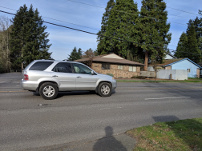

----- image2 -----


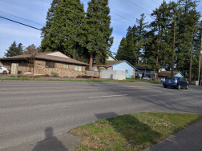

----- Result -----


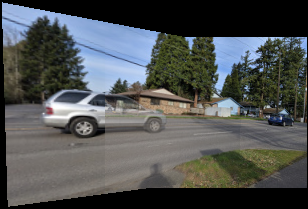

In [7]:
# Visualization
img_1 = cv2.imread('im3.jpg')
img_2 = cv2.imread('im4.jpg')
img_panorama = stitch_images(img_1=img_1, img_2=img_2)


print('----- image1 -----')
cv2_imshow(img_1)
print('----- image2 -----')
cv2_imshow(img_2)
print('----- Result -----')
cv2_imshow(img_panorama)